In [1]:
import pandas as pd

train = pd.read_csv("../api_example/dataset/census+income+kdd/census/census-income-train.csv")
test = pd.read_csv("../api_example/dataset/census+income+kdd/census/census-income-test.csv")

print(train.shape)
print(test.shape)

(199523, 42)
(99762, 42)


In [2]:
categorical_cols = train.select_dtypes(include=["object", "category"]).columns
numeric_cols = train.select_dtypes(exclude=["object", "category"]).columns.tolist()

In [12]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
import lightgbm as lgb


X_train = train.drop(columns=["income"])
y_train = train["income"]
X_test = test.drop(columns=["income"])
y_test = test["income"]
categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols = X_train.select_dtypes(exclude=["object", "category"]).columns.tolist()


for col in categorical_cols:
    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")

model = lgb.LGBMClassifier(
    random_state=42,
    verbosity=-1
)

model.fit(
    X_train,
    y_train,
    categorical_feature=categorical_cols
)

pred_proba = model.predict_proba(X_test)[:, 1]
auc_cat = roc_auc_score(y_test, pred_proba)
pred = model.predict(X_test)
f1_cat = f1_score(y_test, pred, average='weighted')
f1_cat_macro = f1_score(y_test, pred, average='macro')

print("AUC full:", auc_cat)
print("F1 full:", f1_cat)
print("F1 full:", f1_cat_macro)


X_full = pd.concat([X_train, X_test])

X_full_ohe = pd.get_dummies(
    X_full,
    columns=categorical_cols,
    drop_first=False
)

X_train_ohe = X_full_ohe.iloc[:len(X_train)]
X_test_ohe = X_full_ohe.iloc[len(X_train):]

print(f'\nOHE shape - {X_train_ohe.shape}')


X_train_num = X_train_ohe[numeric_cols]
X_test_num = X_test_ohe[numeric_cols]

# Бинарные признаки (всё остальное)
binary_cols = [col for col in X_train_ohe.columns if col not in numeric_cols]

X_train_categorical_only_ohe = X_train_ohe[binary_cols]
X_test_categorical_only_ohe = X_test_ohe[binary_cols]

model_cat_ohe = lgb.LGBMClassifier(
    random_state=42,
    verbosity=-1
)

model_cat_ohe.fit(X_train_categorical_only_ohe, y_train)

pred_proba = model_cat_ohe.predict_proba(X_test_categorical_only_ohe)[:, 1]
auc_ohe = roc_auc_score(y_test, pred_proba)
pred = model_cat_ohe.predict(X_test_categorical_only_ohe)
f1_ohe = f1_score(y_test, pred, average='weighted')
f1_ohe_macro = f1_score(y_test, pred, average='macro')

print("AUC with OHE only categorical:", auc_ohe)
print("F1 with OHE only categorical:", f1_ohe)
print("F1 macro with OHE only categorical:", f1_ohe_macro, '\n')

category_cols = [col for col in X_train.columns if col not in numeric_cols]

X_train_categorical_only = X_train[category_cols]
X_test_categorical_only = X_test[category_cols]

model_cat = lgb.LGBMClassifier(
    random_state=42,
    verbosity=-1
)

model_cat.fit(X_train_categorical_only, y_train)

pred_proba = model_cat.predict_proba(X_test_categorical_only)[:, 1]
auc_ohe = roc_auc_score(y_test, pred_proba)
pred = model_cat.predict(X_test_categorical_only)
f1_ohe = f1_score(y_test, pred, average='weighted')
f1_ohe_macro = f1_score(y_test, pred, average='macro')

print("AUC without OHE only categorical:", auc_ohe)
print("F1 without OHE only categorical:", f1_ohe)
print("F1 macro without OHE only categorical:", f1_ohe_macro, '\n')

sample_idx = np.random.choice(np.arange(len(X_train)), size=20000, replace=False)
X_train_sampled = X_train_categorical_only.iloc[sample_idx]
y_train_sampled = y_train.iloc[sample_idx]

model_cat_sampled = lgb.LGBMClassifier(
    random_state=42,
    verbosity=-1
)

model_cat_sampled.fit(X_train_sampled, y_train_sampled)

pred_proba = model_cat_sampled.predict_proba(X_test_categorical_only)[:, 1]
auc_ohe = roc_auc_score(y_test, pred_proba)
pred = model_cat_sampled.predict(X_test_categorical_only)
f1_ohe = f1_score(y_test, pred, average='weighted')
f1_ohe_macro = f1_score(y_test, pred, average='macro')

print("AUC only categorical with random 20000 samples:", auc_ohe)
print("F1 only categorical with random 20000 samples:", f1_ohe)
print("F1 macro only categorical with random 20000 samples:", f1_ohe_macro)

AUC full: 0.9553217820448046
F1 full: 0.9530424229243234
F1 full: 0.779158738214784

OHE shape - (199523, 408)
AUC with OHE only categorical: 0.928256299452102
F1 with OHE only categorical: 0.9371772720524862
F1 macro with OHE only categorical: 0.6893428346836602 

AUC without OHE only categorical: 0.9288304829295018
F1 without OHE only categorical: 0.9384782331180369
F1 macro without OHE only categorical: 0.6980052378110123 

AUC only categorical with random 20000 samples: 0.9197407882293898
F1 only categorical with random 20000 samples: 0.9359243360948138
F1 macro only categorical with random 20000 samples: 0.6877567414837162


In [4]:
# получаем label encoding представления, чтобы можно было проще сравнивать категории (в кернелах в итоге смотрится одинаковые ли числа, что ок)
X_full = pd.concat([X_train, X_test])
X_full_le = X_full.copy()

for col in categorical_cols:
    X_full_le[col] = X_full_le[col].astype("category").cat.codes
X_train_le = X_full_le.iloc[:len(X_train)]
X_test_le = X_full_le.iloc[len(X_train):]
X_train_num = X_train_le[numeric_cols]
X_test_num = X_test_le[numeric_cols]

X_train_cat_le = X_train_le[categorical_cols]
X_test_cat_le = X_test_le[categorical_cols]

In [5]:
X_train_cat_le.shape

(199523, 28)

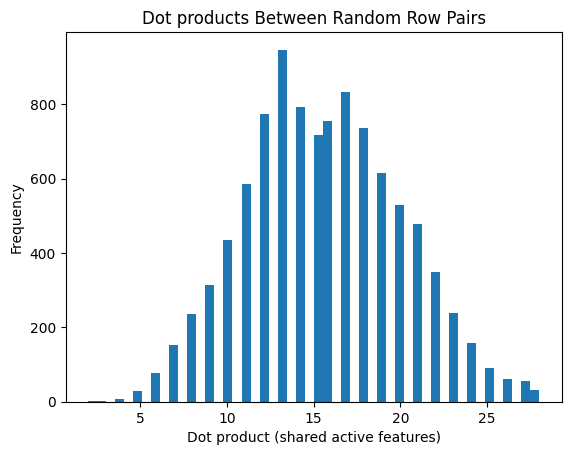

In [6]:
# смотрим скалярные произведения между 10000 рандомными строками в OHE формате (то есть количество совпадений просто)
import numpy as np
import matplotlib.pyplot as plt

X = X_train_categorical_only_ohe[:100000].to_numpy(dtype=np.float32)
n_rows = X.shape[0]
n_pairs = 10000

rng = np.random.default_rng(42)
pairs = rng.choice(n_rows, size=(n_pairs, 2), replace=True)
row_i = X[pairs[:, 0]]
row_j = X[pairs[:, 1]]

dot_products = np.sum(row_i * row_j, axis=1)

plt.hist(dot_products, bins=50)
plt.title("Dot products Between Random Row Pairs")
plt.xlabel("Dot product (shared active features)")
plt.ylabel("Frequency")
plt.show()

In [7]:
from core.sampling_strategies.kernel_sampler import KernelSampler
import torch
from itertools import product
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# для подсчета сколько общих индексов с разными настройками kernel-ов
def pairwise_overlap(tensors):
    n = len(tensors)
    result = torch.zeros((n, n), dtype=torch.float32)

    tensors = [torch.unique(t) for t in tensors]

    for i in range(n):
        for j in range(n):
            a, b = tensors[i], tensors[j]

            inter = torch.isin(a, b).sum()
            union = len(a) + len(b) - inter

            result[i, j] = inter / union * 100

    return result

In [14]:
from pytorch_tabnet.tab_model import TabNetClassifier

device = "cuda" if torch.cuda.is_available() else "cpu"

x_torch_train = torch.from_numpy(X_train_cat_le.to_numpy()).to(device=device, dtype=torch.long)
x_torch_test = torch.from_numpy(X_test_cat_le.to_numpy()).to(device=device, dtype=torch.long)

for anchors in [256, 512, 1024]:
    returned_idxs = []
    for sigma, c in product([0.5, 1, 1.5], [(2, 3), (3, 4)]):
        kernels = [dict(name=f"mC_c{c}", kind="mC", c=mc, weight=1.0) for mc in c]
        kernels.extend([dict(name="mdnf", kind="mdnf", sigma=sigma, weight=1.0), dict(name="match", kind="match", weight=2)])
        # это примерно соответствует balanced сэмплеру с преимущественно density score, потому что так лучше получается
        sampler = KernelSampler(sample_size=20000, kernels=kernels, energy_score=0, density_score=0.7, leverage_score=0.3, anchors=anchors, random_state=int(sigma*2 + c[0] * 5))
        idx, A, embeddings_train = sampler.fit_sample(x_torch_train, y=None)
        embeddings_test = sampler.get_embeddings(x_torch_test, device=device)
        returned_idxs.append(idx)

        X_train_emb = embeddings_train.cpu().numpy()
        X_test_emb = embeddings_test.cpu().numpy()
        y_train_sample = y_train.iloc[idx.cpu().numpy()]

        scaler = StandardScaler()
        X_train_emb = scaler.fit_transform(X_train_emb)
        X_test_emb = scaler.transform(X_test_emb)

        # с PCA получается хуже
        # pca = PCA(n_components=0.92, svd_solver='full')
        # pca.fit(X_train_emb)
        # X_train_emb = pca.transform(X_train_emb)
        # X_test_emb = pca.transform(X_test_emb)

        print("Train shape:", X_train_emb.shape)
        print("Test shape:", X_test_emb.shape)

        # TabNet ожидает numpy float32
        X_train_emb = np.array(X_train_emb, dtype=np.float32)
        X_test_emb = np.array(X_test_emb, dtype=np.float32)
        y_train_sample = np.array(y_train_sample)
        y_test_np = np.array(y_test)

        X_train_emb, X_val, y_train_sample, y_val = train_test_split(
            X_train_emb,
            y_train_sample,
            test_size=0.2,
            random_state=42,
            stratify=y_train_sample
        )

        model_emb = TabNetClassifier(
            seed=42,
            verbose=0
        )

        model_emb.fit(
            X_train_emb,
            y_train_sample,
            eval_set=[(X_val, y_val)],
            eval_name=["val"],
            eval_metric=["auc"],
            max_epochs=100,
            patience=10,
            batch_size=1024,
            virtual_batch_size=128
        )

        pred_emb = model_emb.predict_proba(X_test_emb)[:, 1]
        auc_emb = roc_auc_score(y_test, pred_emb)
        pred_emb = model_emb.predict(X_test_emb)
        f1_emb = f1_score(y_test, pred_emb, average='weighted')
        f1_emb_macro = f1_score(y_test, pred_emb, average='macro')

        print(f"anchors: {anchors}, sigma: {sigma}, c: {c}")
        print("AUC with emb:", auc_emb)
        print("F1 with emb:", f1_emb)
        print("F1 macro with emb:", f1_emb_macro, '\n')

    idx_overlap = pairwise_overlap(returned_idxs)
    print(idx_overlap)

Train shape: (20000, 1024)
Test shape: (99762, 1024)

Early stopping occurred at epoch 46 with best_epoch = 36 and best_val_auc = 0.88251


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


anchors: 256, sigma: 0.5, c: (2, 3)
AUC with emb: 0.894976091467989
F1 with emb: 0.9298442837871351
F1 macro with emb: 0.6498735795427428 

Train shape: (20000, 1024)
Test shape: (99762, 1024)

Early stopping occurred at epoch 48 with best_epoch = 38 and best_val_auc = 0.90477


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


anchors: 256, sigma: 0.5, c: (3, 4)
AUC with emb: 0.8953507417709936
F1 with emb: 0.9337707991922495
F1 macro with emb: 0.681997698649086 

Train shape: (20000, 1024)
Test shape: (99762, 1024)

Early stopping occurred at epoch 67 with best_epoch = 57 and best_val_auc = 0.90919


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


anchors: 256, sigma: 1, c: (2, 3)
AUC with emb: 0.9024214289279908
F1 with emb: 0.933641882670431
F1 macro with emb: 0.6812443095456864 

Train shape: (20000, 1024)
Test shape: (99762, 1024)

Early stopping occurred at epoch 55 with best_epoch = 45 and best_val_auc = 0.8904


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


anchors: 256, sigma: 1, c: (3, 4)
AUC with emb: 0.9019174894132123
F1 with emb: 0.9285756710524804
F1 macro with emb: 0.6390661308677434 

Train shape: (20000, 1024)
Test shape: (99762, 1024)

Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_auc = 0.89387


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


anchors: 256, sigma: 1.5, c: (2, 3)
AUC with emb: 0.8676312353089117
F1 with emb: 0.9119459255976305
F1 macro with emb: 0.512975910647835 

Train shape: (20000, 1024)
Test shape: (99762, 1024)

Early stopping occurred at epoch 58 with best_epoch = 48 and best_val_auc = 0.90609


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


anchors: 256, sigma: 1.5, c: (3, 4)
AUC with emb: 0.9015060677695937
F1 with emb: 0.9337413118135375
F1 macro with emb: 0.6814666517488509 

tensor([[100.0000,   5.5047,   5.4352,   5.2521,   5.2909,   5.2604],
        [  5.5047, 100.0000,   5.4046,   5.3380,   5.5799,   5.3297],
        [  5.4352,   5.4046, 100.0000,   5.3907,   5.3991,   5.5437],
        [  5.2521,   5.3380,   5.3907, 100.0000,   5.4825,   5.5827],
        [  5.2909,   5.5799,   5.3991,   5.4825, 100.0000,   5.4546],
        [  5.2604,   5.3297,   5.5437,   5.5827,   5.4546, 100.0000]])
Train shape: (20000, 2048)
Test shape: (99762, 2048)

Early stopping occurred at epoch 47 with best_epoch = 37 and best_val_auc = 0.90022


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


anchors: 512, sigma: 0.5, c: (2, 3)
AUC with emb: 0.8980561246385004
F1 with emb: 0.9292668232291078
F1 macro with emb: 0.6483937841991724 

Train shape: (20000, 2048)
Test shape: (99762, 2048)

Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_auc = 0.90136


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


anchors: 512, sigma: 0.5, c: (3, 4)
AUC with emb: 0.8983047801295129
F1 with emb: 0.9192810545910173
F1 macro with emb: 0.5684681975708413 

Train shape: (20000, 2048)
Test shape: (99762, 2048)

Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_auc = 0.90344


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


anchors: 512, sigma: 1, c: (2, 3)
AUC with emb: 0.9007730776384338
F1 with emb: 0.9341090582691136
F1 macro with emb: 0.6823092322500599 

Train shape: (20000, 2048)
Test shape: (99762, 2048)

Early stopping occurred at epoch 38 with best_epoch = 28 and best_val_auc = 0.88395


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


anchors: 512, sigma: 1, c: (3, 4)
AUC with emb: 0.8979900146552593
F1 with emb: 0.9184059340185682
F1 macro with emb: 0.5632156043622437 

Train shape: (20000, 2048)
Test shape: (99762, 2048)

Early stopping occurred at epoch 37 with best_epoch = 27 and best_val_auc = 0.90147


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


anchors: 512, sigma: 1.5, c: (2, 3)
AUC with emb: 0.8973141211193698
F1 with emb: 0.929588068152294
F1 macro with emb: 0.6496236166514607 

Train shape: (20000, 2048)
Test shape: (99762, 2048)

Early stopping occurred at epoch 56 with best_epoch = 46 and best_val_auc = 0.89618


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


anchors: 512, sigma: 1.5, c: (3, 4)
AUC with emb: 0.8943496562533092
F1 with emb: 0.9320667651280234
F1 macro with emb: 0.6809451150843027 

tensor([[100.0000,   5.5799,   5.4519,   5.2853,   5.2687,   5.2493],
        [  5.5799, 100.0000,   5.3935,   5.3935,   5.5437,   5.3658],
        [  5.4519,   5.3935, 100.0000,   5.4380,   5.4185,   5.5186],
        [  5.2853,   5.3935,   5.4380, 100.0000,   5.4880,   5.4825],
        [  5.2687,   5.5437,   5.4185,   5.4880, 100.0000,   5.4769],
        [  5.2493,   5.3658,   5.5186,   5.4825,   5.4769, 100.0000]])
Train shape: (20000, 4096)
Test shape: (99762, 4096)

Early stopping occurred at epoch 56 with best_epoch = 46 and best_val_auc = 0.8916


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


anchors: 1024, sigma: 0.5, c: (2, 3)
AUC with emb: 0.8909262782153681
F1 with emb: 0.9272252766493703
F1 macro with emb: 0.634431935323284 

Train shape: (20000, 4096)
Test shape: (99762, 4096)

Early stopping occurred at epoch 38 with best_epoch = 28 and best_val_auc = 0.89884


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


anchors: 1024, sigma: 0.5, c: (3, 4)
AUC with emb: 0.8940711594084285
F1 with emb: 0.9204298222123373
F1 macro with emb: 0.5799921865720108 

Train shape: (20000, 4096)
Test shape: (99762, 4096)

Early stopping occurred at epoch 45 with best_epoch = 35 and best_val_auc = 0.90206


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


anchors: 1024, sigma: 1, c: (2, 3)
AUC with emb: 0.8961930931911795
F1 with emb: 0.9290834557450317
F1 macro with emb: 0.6457505087648467 

Train shape: (20000, 4096)
Test shape: (99762, 4096)

Early stopping occurred at epoch 41 with best_epoch = 31 and best_val_auc = 0.88951


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


anchors: 1024, sigma: 1, c: (3, 4)
AUC with emb: 0.8977822152496346
F1 with emb: 0.9264497046442821
F1 macro with emb: 0.6310242627315148 

Train shape: (20000, 4096)
Test shape: (99762, 4096)

Early stopping occurred at epoch 44 with best_epoch = 34 and best_val_auc = 0.90939


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


anchors: 1024, sigma: 1.5, c: (2, 3)
AUC with emb: 0.8939882759722879
F1 with emb: 0.9237351247882231
F1 macro with emb: 0.6055742033284095 

Train shape: (20000, 4096)
Test shape: (99762, 4096)

Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_auc = 0.90191


/home/artem/PycharmProjects/Sampling-Zoo/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


anchors: 1024, sigma: 1.5, c: (3, 4)
AUC with emb: 0.8944687608117469
F1 with emb: 0.9296329217236742
F1 macro with emb: 0.6429830614137136 

tensor([[100.0000,   5.5771,   5.4519,   5.3325,   5.2576,   5.2465],
        [  5.5771, 100.0000,   5.3769,   5.3769,   5.5632,   5.3130],
        [  5.4519,   5.3769, 100.0000,   5.4574,   5.4102,   5.5075],
        [  5.3325,   5.3769,   5.4574, 100.0000,   5.4908,   5.5019],
        [  5.2576,   5.5632,   5.4102,   5.4908, 100.0000,   5.4685],
        [  5.2465,   5.3130,   5.5075,   5.5019,   5.4685, 100.0000]])
